In [1]:
include("../src/GaPSE.jl");

In [2]:
using TwoFAST, QuadGK, Plots, LaTeXStrings, DelimitedFiles, Dierckx 
using NumericIO

In [3]:
FILE_F_MAP = "../data/F_REFERENCE.txt"
#FILE_PS = "../data/WideA_ZA_pk.dat"
FILE_PS = "file_pk.txt"
FILE_BACKGROUND = "../data/WideA_ZA_background.dat"
#FILE_IS = "tab_xi.txt"

z_min = 0.05
z_max = 0.20
θ_max = π / 2.0
params = GaPSE.CosmoParams(z_min, z_max, θ_max;
  k_min = 1e-8, k_max = 10.0,
  Ω_b = 0.0489, Ω_cdm = 0.251020, h_0 = 0.70,
    N = 1024, fit_min = 1.0, fit_max= 6.0, con=true)

cosmo = GaPSE.Cosmology(params, FILE_BACKGROUND, FILE_PS, FILE_F_MAP; expand=false)

GaPSE.parameters_used(stdout, cosmo)


l_si, l_b, l_a = -2.000242357337959 , -16.806448990730537 , 0.10652839317486584
r_si, r_b, r_a = -3.5538083303331316 , -18185.65287389777 , 2.486997203070703e-10
# The following parameters were used for this computation: 
# CLASS Power Spectrum input file : "file_pk.txt"
# F window function input file : "../data/F_REFERENCE.txt"
# CLASS Background input file: "../data/WideA_ZA_background.dat"
# 	 z_min = 0.05 	 z_max = 0.2
# 	 k_min = 1.0e-8 	 k_max = 10.0
# 	 h_0 = 0.7 	 Ω_b = 0.0489 	 Ω_cdm = 0.25102 	 Ω_M0 = 0.29992
# 	 comoving s_min = 148.1920001343431 Mpc/h_0
# 	 comoving s_max = 571.7022420911966 Mpc/h_0
# 	 comoving s_eff = 435.37470960794167 Mpc/h_0
# 	 comoving z_eff = 0.15045636097417317 
# 	 Volume of the survey V_survey = 3.845366169354268e8
# 	 σ_0 = 15.593462966741178
# 	 σ_1 = 15.074895881392285
# 	 σ_2 = 100.85852368830221
# 	 σ_3 = 15.593462966741178
# 


Castorina convenction for $\xi$:

$$
    \xi_\ell^m(s) = \int_{0}^{\infty} \frac{\mathrm{d} k}{2\pi^2} 
        P(k) \, k^{2-m} \, j_\ell(k r)
$$

mcfit convenction for $\xi$:

$$
    \xi_\ell^n(s) = \int_{0}^{\infty} \frac{\mathrm{d} k}{2\pi^2} 
        P(k) \, k^{2+n} \, j_\ell(k r) 
$$

TwoFAST convenction for $\xi$:

$$
    \xi_\ell^\nu(r) := \int_{0}^{\infty} \frac{\mathrm{d}k}{2\pi^2}
        P(k) \, k^2 \, \frac{j_\ell(kr)}{(kr)^\nu}
$$

The main order $\ell$ is the same for all the three forms, but the second order is defined differently.

$\xi$ mcfit -> $\xi$ Castorina :     $ \quad n \rightarrow m := -n$

$$ \ell, m \mid_{\mathrm{Castorina}} \quad \Rightarrow \quad \xi_\ell^m (r) \mid_{\mathrm{Castorina}} \; = \; \xi_\ell^{-m} (r) \mid_{\mathrm{mcfit}} $$

$\xi$ Castorina -> $\xi$ mcfit :     $ \quad m \rightarrow n := -m$

$$ \ell, n \mid_{\mathrm{mcfit}} \quad \Rightarrow \quad \xi_\ell^{n} (r) \mid_{\mathrm{mcfit}} \; = \; \xi_\ell^{-n} (r) \mid_{\mathrm{Castorina}} $$

$\xi$ TwoFAST -> $\xi$ Castorina :     $ \quad \nu \rightarrow m := \nu \; \land \; \mathrm{multiply \; for \;} r^{m}$ 

$$ \ell, m \mid_{\mathrm{Castorina}} \quad \Rightarrow \quad \xi_\ell^m (r) \mid_{\mathrm{Castorina}} \; = \; r^{m} \, \xi_\ell^{m} (r) \mid_{\mathrm{TwoFAST}} $$


$\xi$ Castorina -> $\xi$ TwoFAST :     $ \quad m \rightarrow \nu := m \; \land \; \mathrm{multiply \; for \;} r^{-\nu}$ 

$$ \ell, \nu \mid_{\mathrm{TwoFAST}} \quad \Rightarrow \quad \xi_\ell^\nu (r) \mid_{\mathrm{TwoFAST}} \; = \; r^{-\nu} \, \xi_\ell^{\nu} (r) \mid_{\mathrm{Castorina}} $$

In [4]:
tab_pk = readdlm("file_pk.txt", comments=true);
ks = convert(Vector{Float64}, tab_pk[:,1]);
k_min, k_max = ks[begin], ks[end]
pks = convert(Vector{Float64}, tab_pk[:,2]);
PK = Spline1D(ks, pks);

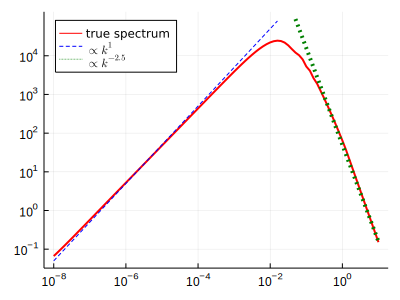

In [5]:
ks = exp10.(range(start=-8,stop=1,step=0.1))
ks_ticks = exp10.(range(start=-8,stop=1,step=2))
pks_ticks = exp10.(range(start=-1,stop=4,step=1))

n_max = argmax(PK.(ks))
plot(ks, PK.(ks), 
    xaxis = :log, yaxis = :log, 
    lw = 2, lc = "red", label="true spectrum",
    legend=:topleft,
    yticks = pks_ticks, xticks = (ks_ticks),
    tickfont = :plain)

plot!(ks[begin:n_max], [x*0.5*1e7 for x in ks[begin:n_max]],
            lw=1, lc="blue", ls=:dash, label=L"$\propto k^{1}$")
plot!(ks[(5+n_max):end], [1.0/x^2.5*0.5*1e2 for x in ks[(5+n_max):end]], 
            lw=4, lc="green", ls=:dot, label=L"$\propto k^{-2.5}$")
plot!(size=(400, 300))

In [6]:
m2 = readdlm("tab_xi.txt");
ss = m2[2:end,1]

ξ00 = Spline1D(ss, m2[2:end,2])
ξ20 = Spline1D(ss, m2[2:end,3])
ξ40 = Spline1D(ss, m2[2:end,4])
ξ02 = Spline1D(ss, m2[2:end,5] ./ ss .^2)
ξ22 = Spline1D(ss, m2[2:end,6] ./ ss .^2)
ξ31 = Spline1D(ss, m2[2:end,7] ./ ss)
ξ11 = Spline1D(ss, m2[2:end,8] ./ ss)

ξs = [ξ00, ξ20, ξ40, ξ02, ξ22, ξ31, ξ11];

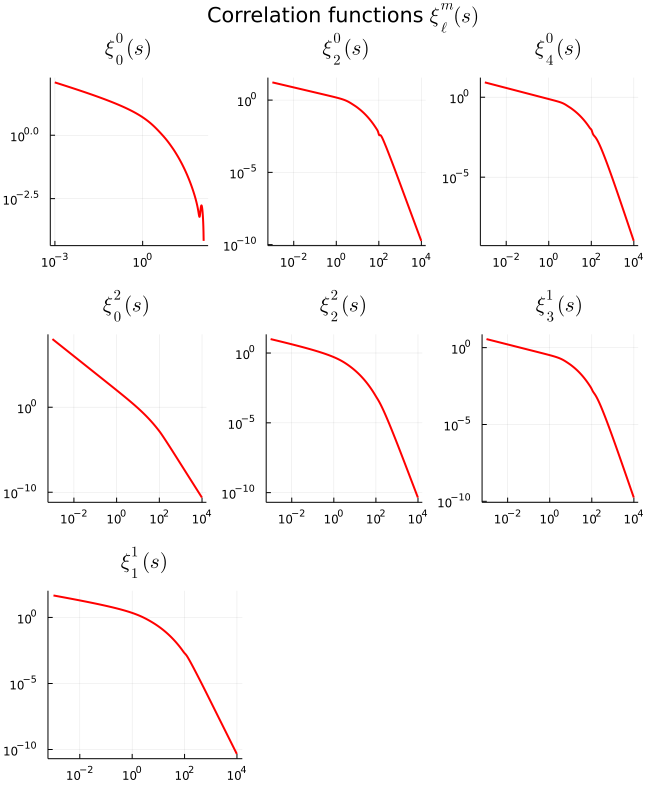

In [7]:
n1,n2 = 200, 1600
ξs_names = [L"$\xi_{0}^{0}(s)$", L"$\xi_{2}^{0}(s)$", L"$\xi_{4}^{0}(s)$",
            L"$\xi_{0}^{2}(s)$", L"$\xi_{2}^{2}(s)$", L"$\xi_{3}^{1}(s)$",
            L"$\xi_{1}^{1}(s)$"]
ps = [plot() for i in 1:7]

title = plot(title = "Correlation functions "* L"$\xi_\ell^m(s)$", grid=false, showaxis = false, bottom_margin = -50Plots.px, ticks=false)
x = ss[n1:n2]
for i in 1:7
    y = ξs[i].(ss[n1:n2])
    ps[i] = plot(x[y.>0], y[y.>0], 
        lw=2, lc="red", title=ξs_names[i], legend=false,
        xaxis=:log, yaxis=:log)
end

l = @layout [A{0.05h}; a b c ; d e f; g _ _ ]
plot(title, ps..., layout=l, size=(650,800))

In [28]:
N = 1024     # number of points to use in the Fourier transform
kmax = 1e3   # maximum k-value
kmin = 1e-5  # minimum k-value
s0 = 1e-3;   # minimum r-value (should be ~1/kmax)

In [29]:
s00, xi00 = xicalc(PK, 0, 0; N=N, kmin=kmin, kmax=kmax, r0=s0)
s20, xi20 = xicalc(PK, 2, 0; N=N, kmin=kmin, kmax=kmax, r0=s0)
s40, xi40 = xicalc(PK, 4, 0; N=N, kmin=kmin, kmax=kmax, r0=s0)
s02, xi02 = xicalc(PK, 0, 2; N=N, kmin=kmin, kmax=kmax, r0=s0)
s22, xi22 = xicalc(PK, 2, 2; N=N, kmin=kmin, kmax=kmax, r0=s0)
s31, xi31 = xicalc(PK, 3, 1; N=N, kmin=kmin, kmax=kmax, r0=s0)
s11, xi11 = xicalc(PK, 1, 1; N=N, kmin=kmin, kmax=kmax, r0=s0);

In [30]:
my_ξ00 = Spline1D(s00, xi00)
my_ξ20 = Spline1D(s20, xi20)
my_ξ40 = Spline1D(s40, xi40)
my_ξ02 = Spline1D(s02, xi02)
my_ξ22 = Spline1D(s22, xi22)
my_ξ31 = Spline1D(s31, xi31)
my_ξ11 = Spline1D(s11, xi11)

my_ξs = [my_ξ00, my_ξ20, my_ξ40, my_ξ02, my_ξ22, my_ξ31, my_ξ11];

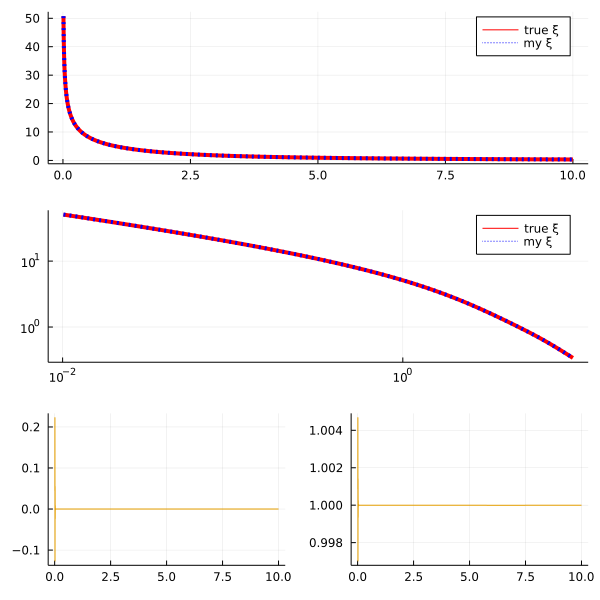

In [31]:
i = 1
x1, x2 = 1e-2, 10.0

x = ss[x1 .< ss .< x2]
y1, y2 = ξs[i].(ss[x1 .< ss .< x2]), my_ξs[i].(ss[x1 .< ss .< x2])

p1 = plot(x, [y1, y2], 
    ls=[:solid :dot], lc=["red" "blue"], label = ["true ξ" "my ξ"], lw=4)
p2 = plot([x[y1.>0], x[y2.>0]], [y1[y1.>0], y2[y2.>0]], 
    ls=[:solid :dot], lc=["red" "blue"], lw=4,
    label = ["true ξ" "my ξ"],
    xaxis=:log, yaxis=:log)
p3 = plot(x, y2 .- y1, legend=false)
p4 = plot(x, y2 ./ y1, legend=false)

l = @layout [a1 ; a2 ; b c]
plot(p1,p2,p3,p4, layout=l, size=(600,600))

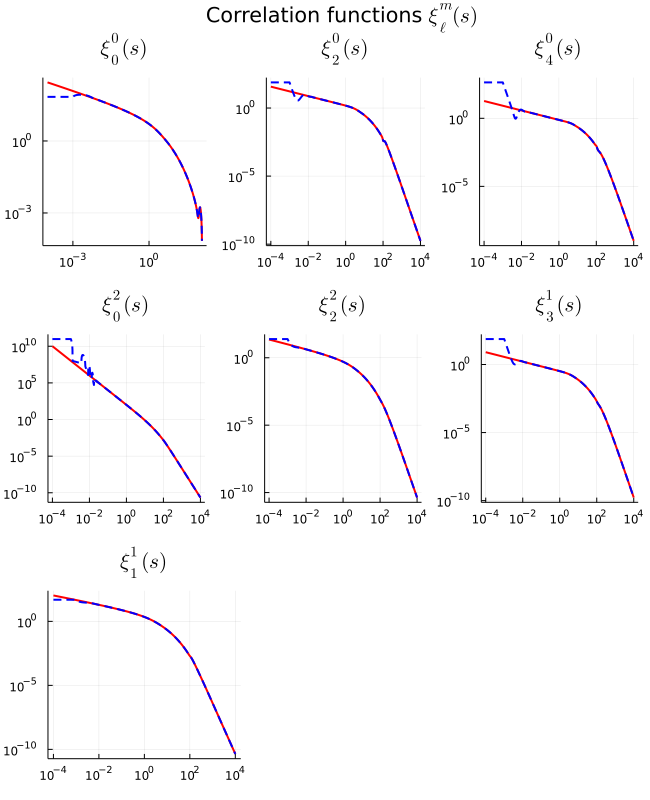

In [32]:
ξs_names = [L"$\xi_{0}^{0}(s)$", L"$\xi_{2}^{0}(s)$", L"$\xi_{4}^{0}(s)$",
            L"$\xi_{0}^{2}(s)$", L"$\xi_{2}^{2}(s)$", L"$\xi_{3}^{1}(s)$",
            L"$\xi_{1}^{1}(s)$"]
ps = [plot() for i in 1:7]

title = plot(title = "Correlation functions "* L"$\xi_\ell^m(s)$", grid=false, showaxis = false, bottom_margin = -50Plots.px, ticks=false)
xs = ss
for i in 1:7
    c_ys = ξs[i].(ss)
    m_ys = my_ξs[i].(ss)
    ps[i] = plot([xs[c_ys.>0], xs[m_ys.>0]], [c_ys[c_ys.>0], m_ys[m_ys.>0] ], 
        lw=2, lc=["red" "blue"], ls=[:solid :dash],
        title=ξs_names[i], legend=false,
        xaxis=:log, yaxis=:log)
end

l = @layout [A{0.05h}; a b c ; d e f; g _ _ ]
plot(title, ps..., layout=l, size=(650,800))

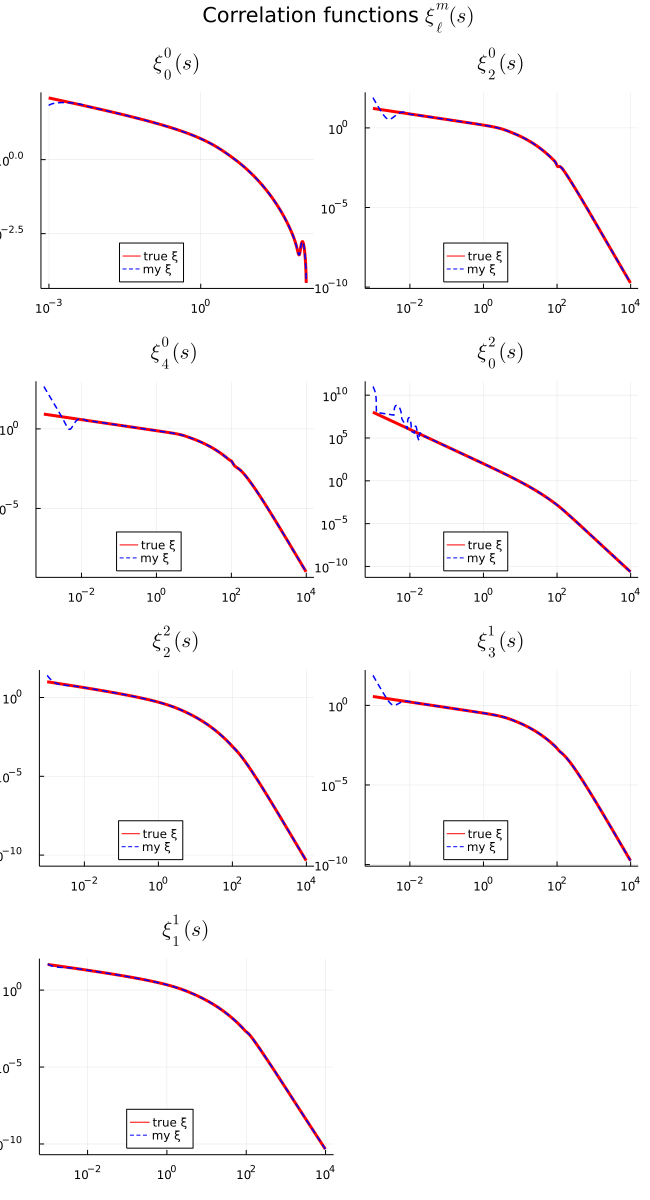

In [13]:
n1,n2 = 200, 1600
ξs = [ξ00, ξ20, ξ40, ξ02, ξ22, ξ31, ξ11]
my_ξs = [my_ξ00, my_ξ20, my_ξ40, my_ξ02, my_ξ22, my_ξ31, my_ξ11]
ξs_names = [L"$\xi_{0}^{0}(s)$", L"$\xi_{2}^{0}(s)$", L"$\xi_{4}^{0}(s)$",
            L"$\xi_{0}^{2}(s)$", L"$\xi_{2}^{2}(s)$", L"$\xi_{3}^{1}(s)$",
            L"$\xi_{1}^{1}(s)$"]
ps = [plot() for i in 1:7]

title = plot(title = "Correlation functions "* L"$\xi_\ell^m(s)$", grid=false, showaxis = false, bottom_margin = -50Plots.px, ticks=false)

x = ss[n1:n2]
for i in 1:7
    y1, y2 = ξs[i].(x), my_ξs[i].(x)
    ps[i] = plot(
        [x[y1.>0], x[y2.>0]],
        [y1[y1.>0], y2[y2.>0]],
        xaxis=:log, yaxis=:log, 
        lc = ["red" "blue"], ls = [:solid :dash],
        lw = [3 1.5],
        label = ["true ξ" "my ξ"],
        title = ξs_names[i], legend=:bottom,
    )
    #=
    p1=plot(ss[n1:n2], ξs[i].(ss[n1:n2]), lc="red")
    ps[i]=plot(p1, ss[n1:n2], my_ξs[i].(ss[n1:n2]), lc="blue",
        xaxis=:log, yaxis=:log)
    =#
end

l = @layout [A{0.05h}; a b ; c d ; e f; g _]
plot(title, ps..., layout=l, size=(650,1200))